## Project: Finding Donors for *CharityML*

In this project, I employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. I then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. The goal is to construct a model that accurately predicts whether an individual makes more than $50,000. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income).

In [9]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display 
import visuals as vs
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

data = pd.read_csv("census.csv")

display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


###  Data Exploration
The following few cells include a cursory exploration of the data. I do this just to get a sense of different features and variables in the data, and a feel for the overall structure of the dataset. 

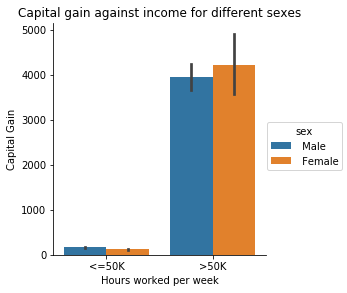

In [10]:
ax1 = sns.factorplot('income', 'capital-gain', hue='sex', data=data, kind='bar')
plt.xlabel("Hours worked per week")
plt.ylabel("Capital Gain")
plt.title("Capital gain against income for different sexes")

plt.show()

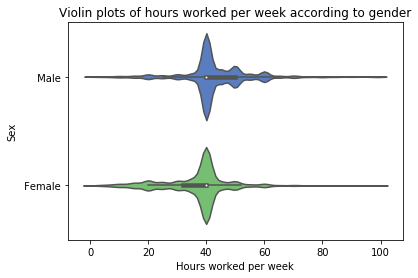

In [11]:
ax2 = sns.violinplot(y='sex', x = 'hours-per-week', data=data, palette="muted")
ax2.set_xlabel("Hours worked per week")
ax2.set_ylabel("Sex")
ax2.set_title("Violin plots of hours worked per week according to gender")
plt.show()

In [12]:
#Total number of records
n_records = data.shape[0]

#Number of records where individual's income is more than $50,000
n_greater_50k = data[data.income !='<=50K'].shape[0]

#Number of records where individual's income is at most $50,000
n_at_most_50k = data[data.income =='<=50K'].shape[0]

#Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k/n_records * 100

print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

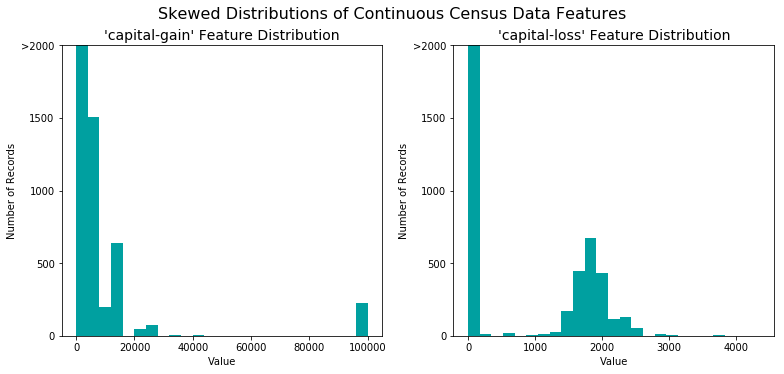

In [13]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. We apply this transformation ont the data and get the following:

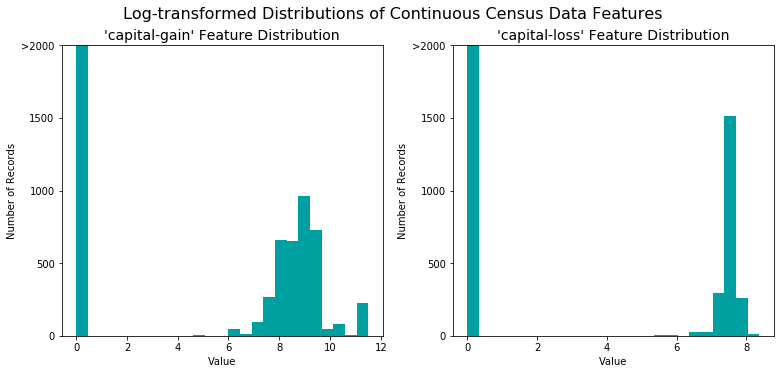

In [14]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features

 We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to normalize each numerical feature.

In [15]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


I now one-hot encode the data

In [16]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.replace({'<=50K':0, '>50K':1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

#print(encoded)

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. I will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [17]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, I will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [18]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
#encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy = TP/(TP+FP)
recall = TP/(TP+FN)
precision = TP/(TP+FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore =(1 + beta**2) * (precision*recall)/((beta**2*precision)+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


**Models I will try, and why **

1) **Gaussian Naive Bayes:** This algorithm can be used in email spam detection. Given a set of words which commonly appear in spam emails, one can check if a given email is spam or not, conditional on how often these words appear in the given email.

   It has a number of strengths: it is relatively simple to understand and build, is easily trained, even with a small dataset, runs very fast, and is not sensitive to irrelevant factors in the dataset. It performs well with datasets with continuous data, which are independent of each other.

   Its main weakness is that it assumes independence in the various factors, which is not always the case. Consequently, it will perform poorly on datasets where there is some correlation between variables.

   This model would be good for the data set because the dataset has a number of continuous variables (hours working per week, age, capital gain, capital loss, etc) which are good predictors of a person's income.
    

2) **Adaptive Boosting** This model is used in face detection - detecting which part of an image is a human face (https://bit.ly/2OhVomg).

   The strength of this model is that it does not require as much tweaking of parameters and settings as other algorithms such Support Vector Machines - it achieves similar classification results with much less effort.
    
   Its main weakness is that it is sensitive to noisy data, and outliers in data.
   
   I think Adaptive Boosting would be a good model for this problem because our data is not noisy, and has few outliers.
    
    
    
3) **Random Forest Classifier**  This model can be used in the banking industry to find loyal customers to a bank - customers who can take out plenty of loans and pay interest to the bank, or fraud customers, who are less likely to pay back loands on time.

   The model has the following strengths (https://dataaspirant.com/2017/05/22/random-forest-algorithm-machine-learing/):
   
        a. It does not overfit when classifying
        b. It can be used in both classification and regression problems
        c. It can be used to identify the most important features in a dataset
        
   The model has the following weaknesses:
   
        a. It predicts much more slowly than other algorithms, especially with large datasets with many decision trees.
        b. It can predict well, bt it does not give any intuition behind the relationships between variables in the data.
        
   Given the similarity between the problem of finding good donors for CharityML and the real-world application of Random Forests in Banking which I presented earlier (because we are looking at similar features for the individuals and trying to predict a similar outcome - whether or not one will be a good donor to a charity, or a loyal customer to a bank), I think Random Forests would be a good fit for the problem of finding good donors for CharityML.


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, I create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. 

In [19]:
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    beta = 0.5
    
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    results['train_time'] = end - start
        
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    results['pred_time'] = end - start
            
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train[:300])
        
    results['acc_test'] = accuracy_score(y_test[:300], predictions_test[:300])
    
    results['f_train'] = fbeta_score(y_train[:300], predictions_train[:300], beta=0.5)
        
    results['f_test'] = fbeta_score(y_test[:300], predictions_test[:300], beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


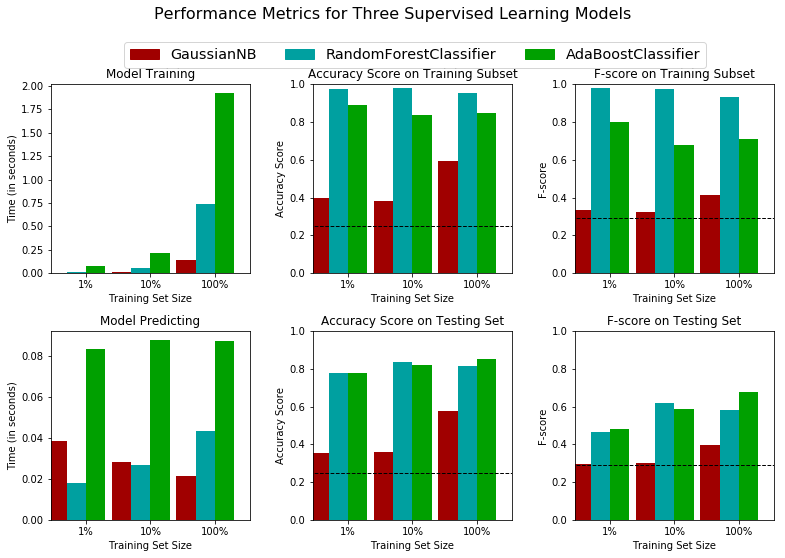

In [20]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# TODO: Initialize the three models
clf_A = GaussianNB()
clf_B = RandomForestClassifier(random_state=0)
clf_C = AdaBoostClassifier(random_state=0)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(0.1 * samples_100)
samples_1 = int(0.01 * samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

### Choosing the Best Model

From the visualizations above, the AdaBoost model has a marginally higher accuracy and F1 score than the Random Forest model when all of the testing data is used. In general, both of these models have significantly higher accuracies and F1 scores than the Gaussian Naive Bayes Algorithm.

   However, the time to train and predict for the AdaBoost model is more than twice that of the Random Forest algorithm. As such, I think the Random Forest model is best for this data, because it provides strong predictions, in decent time.

### Describing the Model in Layman's Terms

The final model chosen is the Random Forest model. As suggested in the name, this model uses a combination of what are called "decision trees" to predict who will be a suitable donor for CharityML. A decision tree is a relatively simple structure for decision making where each decision leads to a conclusion or a further set of decisions. For example, we may have a decision tree that says that if a person is white, male, married and has a bachelor's degree, he earns more than $50,000.

What the Random Forest Algorithm does is that it combines many such trees, and lets them vote when making a prediction. So when we have a new point in the data, the model makes all the individual trees make a prediction, and then picks the prediction which occurs the highest number of times.

### Implementation: Model Tuning
I use GridSearch to fine-tune the model

In [21]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score

# TODO: Initialize the classifier
clf = RandomForestClassifier(random_state=0)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {"max_depth": [2, 5, 10, 20],
              "n_estimators": [2, 5, 10, 20],
              "min_samples_split": list(range(2, 5)),
              "min_samples_leaf": list(range(1, 5)),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8378
F-score on testing data: 0.6717

Optimized Model
------
Final accuracy score on the testing data: 0.8597
Final F-score on the testing data: 0.7314


### Final Model Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |   0.8360          |  0.8612         |
| F-score        |   0.8911          |  0.8915         |


The optimized model performs better than the unoptimized model - it is more accurate and has a higher F score than does the unoptimized model. However, the difference in F-score is only marginal.

These results are also much better than those obtained using the naive predictor benchmarks. There is a significant improvement in accuracy (0.7522 to 0.8612) and F-score (0.6331 to 0.8915).

----
## Feature Importance



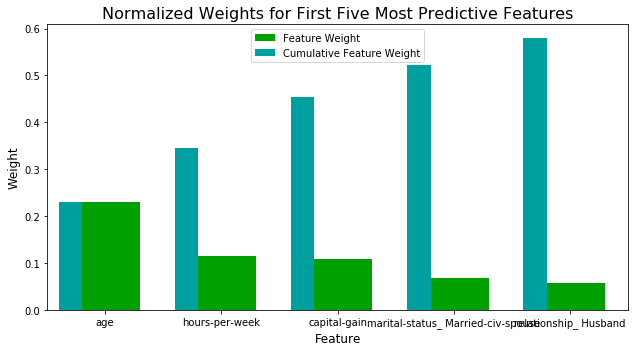

In [22]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

importances = model.feature_importances_

vs.feature_plot(importances, X_train, y_train)

### Feature Selection
The code cell below will use the same optimized model I found earlier, and train it on the same training set with only the top five important features. 

In [23]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8597
F-score on testing data: 0.7314

Final Model trained on reduced data
------
Accuracy on testing data: 0.8150
F-score on testing data: 0.6188


###Effects of Feature Selection

There is a 1.5% decrease in accuracy and a 4% reduction in F-score when the number of features is reduced. 

If training time was a factor, I definitely would consider using the reduced data as my training set, given that the loss in accuracy and F-score is not large enough to be significant.

In [24]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook finding_donors.ipynb to html',
 '[NbConvertApp] Writing 460409 bytes to finding_donors.html']